In [1]:
import matplotlib
from matplotlib import pylab as plt
import numpy as np
import pandas as pd
import nibabel as nib
from nibabel import nifti1
from nibabel.viewers import OrthoSlicer3D
from tqdm import tqdm
import os
from PIL import Image as im
from pathlib import Path
import torch
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('../tensorboard_logs')

2023-06-19 14:49:38.138068: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96, got 80
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 232, got 216
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject


In [2]:
np.expand_dims(np.asarray([1,2]), axis=0)

array([[1, 2]])

In [2]:
data = np.load('/vol/space/projects/ukbb/projects/silhouette/eids_filtered.npy')


In [3]:
data.shape

(25298,)

In [4]:
DATA_ROOT = "/vol/space/projects/ukbb/projects/silhouette/silhouettes/vat_sat_subjects"
TARGET_ROOT = "/vol/space/projects/ukbb/projects/silhouette/silhouettes/v1"
FEATURES_ROOT = "/vol/space/projects/ukbb/projects/silhouette/ukb668815_imaging.csv"
EXTENSION = ".jpg"
SIZE = (392, 363)
LIMIT = 3000

In [5]:
features = pd.read_csv(FEATURES_ROOT, usecols =["eid", "31-0.0"]).set_index('eid')

In [6]:
arr = np.array([1])

In [7]:
arr[0] == 1 


True

In [8]:
features

,31-0.0
eid,
1000071,0
1000109,0
1000125,1
1000180,1
1000191,1
...,...
6023367,1
6023419,1
6023708,0


In [9]:
features[features.index.isin(np.array([1000071,6023708,6023419]))]

,31-0.0
eid,
1000071,0
6023419,1
6023708,0


In [4]:
def process(DATA_ROOT, LIMIT , TARGET_ROOT, SIZE, EXTENSION):
    COUNT = 0

    for file in tqdm(os.listdir(DATA_ROOT)):
        _path = str(os.path.join(str(DATA_ROOT), file).replace('\\', '/')) +'/body_mask.nii.gz'
        _id = _path[_path[:_path.rfind("/")].rfind("/")+1:_path.rfind("/",0,)]
        
        if (LIMIT > COUNT) :
            if(os.path.exists(_path)):
            
                body_segment = nib.load(_path)
                body_segment_data = body_segment.get_fdata()

                slh_coronal = create_silhouette(body_segment_data, 1)
                slh_sagittal = create_silhouette(body_segment_data, 0)
                concatenated_sil = cat_silhouette(slh_coronal, slh_sagittal, SIZE)

                _target_path =  TARGET_ROOT + "/" + _id + EXTENSION

                concatenated_sil.save(_target_path)

                COUNT += 1
            else:
                continue
        else:
            break

def create_silhouette(body_segment_data: np.ndarray, direction: int) -> np.ndarray:
    tmp = body_segment_data.mean(axis=direction)
    shape = tmp.shape
    oneD_data = np.ravel(tmp)
    slh = []

    for i in range(oneD_data.shape[0]):
        if oneD_data[i] != 0.:
            slh.append(255.)
        else:
            slh.append(0.)   
            
    slh = np.array(slh).reshape(shape)

    if direction == 0: # transpose sagittal slh
        slh = np.asarray(im.fromarray(slh).transpose(im.FLIP_TOP_BOTTOM))

    return slh

def cat_silhouette(slh_coronal: np.ndarray, slh_sagittal: np.ndarray, size: tuple) -> im.Image:
    concatenated_slh = np.concatenate((slh_coronal, slh_sagittal), 0)
    slh_image = im.fromarray(concatenated_slh)

    return slh_image.resize((max(size),max(size))).rotate(90).resize(size).convert('L') 

def read_jpgs(root_path: str):
    ids = []
    imgs = []

    for file in tqdm(os.listdir(root_path)):
        _path = str(os.path.join(str(root_path), file).replace('\\', '/'))
        _id = int(file.replace('.jpg',""))

        img = im.open(_path)

        ids.append(_id)
        imgs.append(np.asarray(img))

    return ids, np.asarray(imgs)

In [20]:
process(DATA_ROOT, LIMIT ,TARGET_ROOT, SIZE)

  0%|          | 0/25299 [00:00<?, ?it/s]/tmp/ipykernel_2176184/4077995118.py:43: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  slh = np.asarray(im.fromarray(slh).transpose(im.FLIP_TOP_BOTTOM))
 12%|█▏        | 3000/25299 [03:43<27:39, 13.44it/s]  


In [5]:
ids, imgs = read_jpgs(TARGET_ROOT)

100%|██████████| 26341/26341 [00:30<00:00, 877.18it/s] 


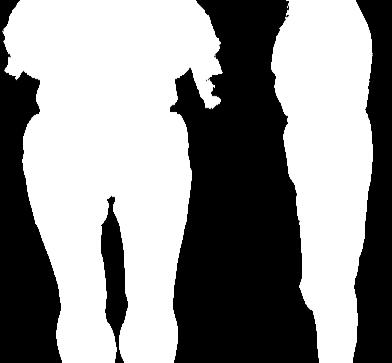

In [6]:
im.fromarray(imgs[0]).show()

In [7]:
imgs.shape

(26341, 363, 392)

In [13]:
FEATURES_ROOT = "/vol/space/projects/ukbb/projects/silhouette/ukb668815_imaging.csv"
BRIDGES_ROOT = "/vol/space/projects/ukbb/projects/silhouette/Bridge_eids_60520_87802.csv"
features = pd.read_csv(FEATURES_ROOT, usecols =["eid", "22407-2.0", "22408-2.0"]).set_index('eid')

In [14]:
features.columns = ["VAT", "ASAT"]

In [15]:
features['VAT'].count()

25581

In [16]:
features['ASAT'].count()

25570

In [17]:
features = features[features.index.isin(ids)]
features.insert(features.shape[1], 'VAT/ASAT', features['VAT']/features['ASAT'])

In [18]:
features['VAT/ASAT'].count()

25299

In [90]:
targets = features['VAT'].dropna()
valid_ids = targets.index.tolist()

d = dict(zip(ids, imgs))
data = [d[id] for id in valid_ids]

In [92]:
len(data)

52

In [72]:
vats.index.tolist()

[1566,
 1729,
 2140,
 2312,
 6685,
 6915,
 7495,
 8881,
 12861,
 12975,
 13419,
 15667,
 15834,
 16557,
 17553,
 18652,
 19552,
 21556,
 21590,
 22884,
 23203,
 26398,
 26417,
 27111,
 27640,
 28769,
 30542,
 30681,
 31525,
 31876,
 32422,
 32663,
 33224,
 33941,
 39186,
 39526,
 40144,
 40748,
 41536,
 41830,
 42779,
 42982,
 43760,
 43987,
 45603,
 46106,
 46194,
 48687,
 49574,
 52171,
 52476,
 53390]

In [55]:
vats = [float(features["VAT"][features['eid'] == id]) for id in ids]
targets = []
data = []

for i in range(len(vats)):
    if math.isnan(vats[i]) == False:
        targets.append(vats[i])
        data.append(imgs[i])

targets = torch.tensor(np.array(targets)).double().reshape((-1,1))
data = torch.tensor(np.array(data)).double()
# data_shape = data.shape
# data = data.reshape((data_shape[0], data_shape[3], data_shape[1], data_shape[2]))

IndexError: tuple index out of range

In [58]:
type(vats)

list

In [53]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(3)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(3)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1, stride=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(3)

        self.fc = nn.Linear(182, 256)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        self.outlayer = nn.Linear(256, 1)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(self.relu1(x))
        x = self.conv2(x)
        x = self.pool2(self.relu2(x))
        x = self.conv3(x)
        x = self.pool3(self.relu3(x))
        
        # print(x.shape)
        s = x.shape

        x = x.view(-1, s[2] * s[3])

        x = self.relu3(self.fc(x))
        x = self.dropout(x)

        x = self.outlayer(x)
        return x

In [12]:
batch_size = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device) 
model = model.double()

x_train, x_val, y_train, y_val = train_test_split(data, targets, test_size=0.3, random_state=42, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42, shuffle=True)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

loss_criterion = torch.nn.MSELoss()
loss_criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()

# best_accuracy = float("-inf")
train_loss_running = 0.

for epoch in range(300):
    for i, train_data in tqdm(enumerate(train_loader)): 
        x_train, y_train = train_data[0], train_data[1]
        x_train = x_train.to(device)
        optimizer.zero_grad()
        prediction = model(x_train)
        y_train = y_train.to(device)
        loss = loss_criterion(prediction, y_train)  
        loss.to(device)
        loss.backward()
        optimizer.step()
        
        # loss logging
        train_loss_running += loss.item()
        iteration = epoch * len(train_loader) + i

        if iteration % 10 == (10 - 1):
            print(f'[{epoch:03d}/{i:05d}] train_loss: {train_loss_running / 10:.3f}')
            writer.add_scalars('dummy_VAT_mse', {'train_mse':train_loss_running / 10}, iteration)
            train_loss_running = 0.
            
        # validation evaluation and logging
        if iteration % 10 == (10 - 1):
            loss_total_val = 0
            _predictions = torch.tensor([])
            _labels = torch.tensor([])

            model.eval()
                
            # forward pass and evaluation for entire validation set
            for val_data in val_loader:
                x_val, y_val = val_data[0], val_data[1]
                x_val = x_val.to(device)
                
                with torch.no_grad():
                    prediction = model(x_val).detach().cpu()
                                
                y_val = y_val.detach().cpu()
                #keep track of loss_total_val                                  
                loss_total_val += loss_criterion(prediction,y_val).item()
                _predictions = torch.cat((_predictions.double(), prediction.double()))
                _labels = torch.cat((_labels.double(), y_val.double()))

            accuracy = r2_score(_labels, _predictions)
            print(f'[{epoch:03d}/{i:05d}] val_loss: {loss_total_val / len(val_loader):.3f}, val_accuracy: {accuracy:.3f}')
            writer.add_scalars('dummy_VAT_mse', {'val_mse':loss_total_val / len(val_loader)}, iteration)

            model.train()

5it [00:01,  3.49it/s]
5it [00:00, 13.38it/s]


[001/00004] train_loss: 37.511
[001/00004] val_loss: 8.639, val_accuracy: 0.195


5it [00:00, 14.30it/s]
5it [00:00, 13.89it/s]


[003/00004] train_loss: 11.022
[003/00004] val_loss: 8.763, val_accuracy: 0.183


5it [00:00, 14.38it/s]
5it [00:00, 13.76it/s]


[005/00004] train_loss: 8.802
[005/00004] val_loss: 6.347, val_accuracy: 0.409


5it [00:00, 14.25it/s]
5it [00:00, 13.81it/s]


[007/00004] train_loss: 5.298
[007/00004] val_loss: 4.497, val_accuracy: 0.581


5it [00:00, 14.36it/s]
5it [00:00, 13.83it/s]


[009/00004] train_loss: 4.177
[009/00004] val_loss: 6.439, val_accuracy: 0.400


5it [00:00, 14.29it/s]
5it [00:00, 13.73it/s]


[011/00004] train_loss: 4.642
[011/00004] val_loss: 3.963, val_accuracy: 0.631


5it [00:00, 14.39it/s]
5it [00:00, 13.88it/s]


[013/00004] train_loss: 2.598
[013/00004] val_loss: 2.648, val_accuracy: 0.753


5it [00:00, 14.40it/s]
5it [00:00, 13.78it/s]


[015/00004] train_loss: 1.836
[015/00004] val_loss: 3.232, val_accuracy: 0.699


5it [00:00, 14.31it/s]
5it [00:00, 13.84it/s]


[017/00004] train_loss: 2.658
[017/00004] val_loss: 3.427, val_accuracy: 0.681


5it [00:00, 14.20it/s]
5it [00:00, 13.80it/s]


[019/00004] train_loss: 2.231
[019/00004] val_loss: 2.563, val_accuracy: 0.761


5it [00:00, 14.15it/s]
5it [00:00, 13.90it/s]


[021/00004] train_loss: 1.657
[021/00004] val_loss: 3.039, val_accuracy: 0.717


5it [00:00, 14.27it/s]
5it [00:00, 13.80it/s]


[023/00004] train_loss: 1.790
[023/00004] val_loss: 2.508, val_accuracy: 0.766


5it [00:00, 14.43it/s]
5it [00:00, 13.69it/s]


[025/00004] train_loss: 0.797
[025/00004] val_loss: 2.490, val_accuracy: 0.768


5it [00:00, 14.28it/s]
5it [00:00, 13.76it/s]


[027/00004] train_loss: 1.275
[027/00004] val_loss: 3.358, val_accuracy: 0.687


5it [00:00, 14.34it/s]
5it [00:00, 13.97it/s]


[029/00004] train_loss: 1.682
[029/00004] val_loss: 3.340, val_accuracy: 0.689


5it [00:00, 14.42it/s]
5it [00:00, 13.73it/s]


[031/00004] train_loss: 1.956
[031/00004] val_loss: 2.254, val_accuracy: 0.790


5it [00:00, 14.24it/s]
5it [00:00, 13.86it/s]


[033/00004] train_loss: 1.285
[033/00004] val_loss: 2.280, val_accuracy: 0.788


5it [00:00, 14.45it/s]
5it [00:00, 13.92it/s]


[035/00004] train_loss: 1.038
[035/00004] val_loss: 2.932, val_accuracy: 0.727


5it [00:00, 14.28it/s]
5it [00:00, 13.80it/s]


[037/00004] train_loss: 0.899
[037/00004] val_loss: 3.721, val_accuracy: 0.653


5it [00:00, 14.34it/s]
5it [00:00, 13.97it/s]


[039/00004] train_loss: 1.364
[039/00004] val_loss: 3.063, val_accuracy: 0.715


5it [00:00, 14.39it/s]
5it [00:00, 13.87it/s]


[041/00004] train_loss: 0.552
[041/00004] val_loss: 2.379, val_accuracy: 0.778


5it [00:00, 14.33it/s]
5it [00:00, 13.92it/s]


[043/00004] train_loss: 1.034
[043/00004] val_loss: 2.557, val_accuracy: 0.762


5it [00:00, 14.30it/s]
5it [00:00, 13.77it/s]


[045/00004] train_loss: 1.071
[045/00004] val_loss: 3.704, val_accuracy: 0.655


5it [00:00, 14.41it/s]
5it [00:00, 13.88it/s]


[047/00004] train_loss: 1.060
[047/00004] val_loss: 3.141, val_accuracy: 0.707


5it [00:00, 14.16it/s]
5it [00:00, 13.79it/s]


[049/00004] train_loss: 0.880
[049/00004] val_loss: 2.431, val_accuracy: 0.773


5it [00:00, 14.35it/s]
5it [00:00, 13.80it/s]


[051/00004] train_loss: 1.072
[051/00004] val_loss: 2.492, val_accuracy: 0.768


5it [00:00, 14.25it/s]
5it [00:00, 13.75it/s]


[053/00004] train_loss: 0.823
[053/00004] val_loss: 2.872, val_accuracy: 0.732


5it [00:00, 14.45it/s]
5it [00:00, 13.87it/s]


[055/00004] train_loss: 1.325
[055/00004] val_loss: 2.248, val_accuracy: 0.790


5it [00:00, 14.16it/s]
5it [00:00, 13.91it/s]


[057/00004] train_loss: 0.753
[057/00004] val_loss: 2.274, val_accuracy: 0.788


5it [00:00, 14.18it/s]
5it [00:00, 13.75it/s]


[059/00004] train_loss: 0.841
[059/00004] val_loss: 2.472, val_accuracy: 0.770


5it [00:00, 14.22it/s]
5it [00:00, 13.86it/s]


[061/00004] train_loss: 0.569
[061/00004] val_loss: 2.314, val_accuracy: 0.784


5it [00:00, 14.21it/s]
5it [00:00, 13.74it/s]


[063/00004] train_loss: 0.646
[063/00004] val_loss: 2.213, val_accuracy: 0.794


5it [00:00, 14.43it/s]
5it [00:00, 13.88it/s]


[065/00004] train_loss: 0.812
[065/00004] val_loss: 1.968, val_accuracy: 0.817


5it [00:00, 14.34it/s]
5it [00:00, 13.78it/s]


[067/00004] train_loss: 0.606
[067/00004] val_loss: 2.258, val_accuracy: 0.790


5it [00:00, 14.34it/s]
5it [00:00, 13.77it/s]


[069/00004] train_loss: 0.789
[069/00004] val_loss: 2.098, val_accuracy: 0.805


5it [00:00, 14.27it/s]
5it [00:00, 13.80it/s]


[071/00004] train_loss: 1.198
[071/00004] val_loss: 2.461, val_accuracy: 0.771


5it [00:00, 14.44it/s]
5it [00:00, 14.02it/s]


[073/00004] train_loss: 0.532
[073/00004] val_loss: 2.318, val_accuracy: 0.784


5it [00:00, 14.40it/s]
5it [00:00, 13.81it/s]


[075/00004] train_loss: 0.577
[075/00004] val_loss: 2.773, val_accuracy: 0.742


5it [00:00, 14.41it/s]
5it [00:00, 13.91it/s]


[077/00004] train_loss: 0.740
[077/00004] val_loss: 2.250, val_accuracy: 0.790


5it [00:00, 14.41it/s]
5it [00:00, 13.92it/s]


[079/00004] train_loss: 0.715
[079/00004] val_loss: 4.193, val_accuracy: 0.609


5it [00:00, 14.52it/s]
5it [00:00, 13.94it/s]


[081/00004] train_loss: 1.365
[081/00004] val_loss: 2.466, val_accuracy: 0.770


5it [00:00, 14.44it/s]
5it [00:00, 13.73it/s]


[083/00004] train_loss: 1.557
[083/00004] val_loss: 2.761, val_accuracy: 0.743


5it [00:00, 14.43it/s]
5it [00:00, 13.89it/s]


[085/00004] train_loss: 0.649
[085/00004] val_loss: 2.609, val_accuracy: 0.757


5it [00:00, 14.36it/s]
5it [00:00, 13.90it/s]


[087/00004] train_loss: 0.370
[087/00004] val_loss: 2.258, val_accuracy: 0.790


5it [00:00, 14.38it/s]
5it [00:00, 13.87it/s]


[089/00004] train_loss: 0.609
[089/00004] val_loss: 2.626, val_accuracy: 0.755


5it [00:00, 14.45it/s]
5it [00:00, 13.92it/s]


[091/00004] train_loss: 0.420
[091/00004] val_loss: 3.030, val_accuracy: 0.718


5it [00:00, 14.44it/s]
5it [00:00, 13.92it/s]


[093/00004] train_loss: 0.781
[093/00004] val_loss: 2.212, val_accuracy: 0.794


5it [00:00, 14.41it/s]
5it [00:00, 13.67it/s]


[095/00004] train_loss: 0.336
[095/00004] val_loss: 2.158, val_accuracy: 0.799


5it [00:00, 14.45it/s]
5it [00:00, 13.85it/s]


[097/00004] train_loss: 0.927
[097/00004] val_loss: 2.460, val_accuracy: 0.771


5it [00:00, 14.37it/s]
5it [00:00, 13.97it/s]


[099/00004] train_loss: 0.416
[099/00004] val_loss: 3.460, val_accuracy: 0.678


5it [00:00, 14.26it/s]
5it [00:00, 13.83it/s]


[101/00004] train_loss: 0.883
[101/00004] val_loss: 3.664, val_accuracy: 0.659


5it [00:00, 14.39it/s]
5it [00:00, 13.91it/s]


[103/00004] train_loss: 2.461
[103/00004] val_loss: 2.296, val_accuracy: 0.786


5it [00:00, 14.30it/s]
5it [00:00, 13.74it/s]


[105/00004] train_loss: 1.413
[105/00004] val_loss: 2.431, val_accuracy: 0.773


5it [00:00, 14.45it/s]
5it [00:00, 13.88it/s]


[107/00004] train_loss: 1.162
[107/00004] val_loss: 2.396, val_accuracy: 0.777


5it [00:00, 14.31it/s]
5it [00:00, 13.87it/s]


[109/00004] train_loss: 1.152
[109/00004] val_loss: 4.032, val_accuracy: 0.624


5it [00:00, 14.43it/s]
5it [00:00, 13.82it/s]


[111/00004] train_loss: 1.117
[111/00004] val_loss: 2.702, val_accuracy: 0.748


5it [00:00, 14.44it/s]
5it [00:00, 13.81it/s]


[113/00004] train_loss: 0.853
[113/00004] val_loss: 2.340, val_accuracy: 0.782


5it [00:00, 14.36it/s]
5it [00:00, 13.80it/s]


[115/00004] train_loss: 0.732
[115/00004] val_loss: 2.112, val_accuracy: 0.803


5it [00:00, 14.38it/s]
5it [00:00, 13.84it/s]


[117/00004] train_loss: 1.335
[117/00004] val_loss: 1.827, val_accuracy: 0.830


5it [00:00, 14.43it/s]
5it [00:00, 13.87it/s]


[119/00004] train_loss: 3.424
[119/00004] val_loss: 3.480, val_accuracy: 0.676


5it [00:00, 14.46it/s]
5it [00:00, 13.85it/s]


[121/00004] train_loss: 2.004
[121/00004] val_loss: 3.236, val_accuracy: 0.698


5it [00:00, 14.38it/s]
5it [00:00, 13.85it/s]


[123/00004] train_loss: 1.220
[123/00004] val_loss: 2.247, val_accuracy: 0.791


5it [00:00, 14.38it/s]
5it [00:00, 14.01it/s]


[125/00004] train_loss: 0.551
[125/00004] val_loss: 2.174, val_accuracy: 0.797


5it [00:00, 14.36it/s]
5it [00:00, 13.82it/s]


[127/00004] train_loss: 0.570
[127/00004] val_loss: 2.223, val_accuracy: 0.793


5it [00:00, 14.47it/s]
5it [00:00, 13.93it/s]


[129/00004] train_loss: 0.494
[129/00004] val_loss: 2.789, val_accuracy: 0.740


5it [00:00, 14.33it/s]
5it [00:00, 13.87it/s]


[131/00004] train_loss: 0.547
[131/00004] val_loss: 2.555, val_accuracy: 0.762


5it [00:00, 14.46it/s]
5it [00:00, 13.72it/s]


[133/00004] train_loss: 0.599
[133/00004] val_loss: 2.626, val_accuracy: 0.755


5it [00:00, 14.46it/s]
5it [00:00, 13.77it/s]


[135/00004] train_loss: 0.728
[135/00004] val_loss: 2.697, val_accuracy: 0.749


5it [00:00, 14.38it/s]
5it [00:00, 13.62it/s]


[137/00004] train_loss: 1.159
[137/00004] val_loss: 2.359, val_accuracy: 0.780


5it [00:00, 14.13it/s]
5it [00:00, 13.77it/s]


[139/00004] train_loss: 0.823
[139/00004] val_loss: 2.649, val_accuracy: 0.753


5it [00:00, 14.38it/s]
5it [00:00, 13.76it/s]


[141/00004] train_loss: 1.512
[141/00004] val_loss: 2.646, val_accuracy: 0.753


5it [00:00, 14.29it/s]
5it [00:00, 13.67it/s]


[143/00004] train_loss: 1.165
[143/00004] val_loss: 3.832, val_accuracy: 0.643


5it [00:00, 14.34it/s]
5it [00:00, 13.77it/s]


[145/00004] train_loss: 1.501
[145/00004] val_loss: 5.094, val_accuracy: 0.525


5it [00:00, 14.20it/s]
5it [00:00, 13.74it/s]


[147/00004] train_loss: 1.528
[147/00004] val_loss: 3.476, val_accuracy: 0.676


5it [00:00, 14.46it/s]
5it [00:00, 13.91it/s]


[149/00004] train_loss: 1.188
[149/00004] val_loss: 3.337, val_accuracy: 0.689


5it [00:00, 14.36it/s]
5it [00:00, 13.77it/s]


[151/00004] train_loss: 1.551
[151/00004] val_loss: 2.657, val_accuracy: 0.752


5it [00:00, 14.44it/s]
5it [00:00, 13.64it/s]


[153/00004] train_loss: 0.910
[153/00004] val_loss: 2.277, val_accuracy: 0.788


5it [00:00, 14.29it/s]
5it [00:00, 13.68it/s]


[155/00004] train_loss: 1.129
[155/00004] val_loss: 2.389, val_accuracy: 0.777


5it [00:00, 14.24it/s]
5it [00:00, 13.66it/s]


[157/00004] train_loss: 0.616
[157/00004] val_loss: 2.416, val_accuracy: 0.775


5it [00:00, 14.39it/s]
5it [00:00, 13.61it/s]


[159/00004] train_loss: 0.584
[159/00004] val_loss: 2.332, val_accuracy: 0.783


5it [00:00, 14.10it/s]
5it [00:00, 13.76it/s]


[161/00004] train_loss: 0.769
[161/00004] val_loss: 2.306, val_accuracy: 0.785


5it [00:00, 14.46it/s]
5it [00:00, 13.84it/s]


[163/00004] train_loss: 0.696
[163/00004] val_loss: 2.141, val_accuracy: 0.800


5it [00:00, 14.38it/s]
5it [00:00, 13.67it/s]


[165/00004] train_loss: 0.756
[165/00004] val_loss: 1.981, val_accuracy: 0.815


5it [00:00, 14.44it/s]
5it [00:00, 13.86it/s]


[167/00004] train_loss: 0.456
[167/00004] val_loss: 2.174, val_accuracy: 0.797


5it [00:00, 14.35it/s]
5it [00:00, 13.82it/s]


[169/00004] train_loss: 0.628
[169/00004] val_loss: 2.292, val_accuracy: 0.786


5it [00:00, 14.36it/s]
5it [00:00, 13.94it/s]


[171/00004] train_loss: 0.873
[171/00004] val_loss: 2.428, val_accuracy: 0.774


5it [00:00, 14.17it/s]
5it [00:00, 13.79it/s]


[173/00004] train_loss: 0.445
[173/00004] val_loss: 2.283, val_accuracy: 0.787


5it [00:00, 14.40it/s]
5it [00:00, 13.51it/s]


[175/00004] train_loss: 0.432
[175/00004] val_loss: 1.996, val_accuracy: 0.814


5it [00:00, 14.25it/s]
5it [00:00, 13.80it/s]


[177/00004] train_loss: 0.623
[177/00004] val_loss: 2.301, val_accuracy: 0.786


5it [00:00, 14.37it/s]
5it [00:00, 13.82it/s]


[179/00004] train_loss: 0.334
[179/00004] val_loss: 2.819, val_accuracy: 0.737


5it [00:00, 14.33it/s]
5it [00:00, 13.76it/s]


[181/00004] train_loss: 0.544
[181/00004] val_loss: 2.546, val_accuracy: 0.763


5it [00:00, 14.38it/s]
5it [00:00, 13.86it/s]


[183/00004] train_loss: 0.342
[183/00004] val_loss: 2.809, val_accuracy: 0.738


5it [00:00, 14.39it/s]
5it [00:00, 13.76it/s]


[185/00004] train_loss: 0.478
[185/00004] val_loss: 2.796, val_accuracy: 0.739


5it [00:00, 14.35it/s]
5it [00:00, 13.92it/s]


[187/00004] train_loss: 0.298
[187/00004] val_loss: 2.481, val_accuracy: 0.769


5it [00:00, 14.22it/s]
5it [00:00, 13.78it/s]


[189/00004] train_loss: 0.334
[189/00004] val_loss: 2.745, val_accuracy: 0.744


5it [00:00, 14.46it/s]
5it [00:00, 13.87it/s]


[191/00004] train_loss: 0.409
[191/00004] val_loss: 2.550, val_accuracy: 0.762


5it [00:00, 14.38it/s]
5it [00:00, 13.65it/s]


[193/00004] train_loss: 0.351
[193/00004] val_loss: 2.538, val_accuracy: 0.763


5it [00:00, 14.44it/s]
5it [00:00, 13.93it/s]


[195/00004] train_loss: 0.410
[195/00004] val_loss: 2.552, val_accuracy: 0.762


5it [00:00, 14.45it/s]
5it [00:00, 13.97it/s]


[197/00004] train_loss: 0.348
[197/00004] val_loss: 2.911, val_accuracy: 0.729


5it [00:00, 14.20it/s]
5it [00:00, 13.76it/s]


[199/00004] train_loss: 0.330
[199/00004] val_loss: 2.564, val_accuracy: 0.761


5it [00:00, 15.00it/s]
5it [00:00, 14.97it/s]


[201/00004] train_loss: 0.434
[201/00004] val_loss: 2.414, val_accuracy: 0.775


5it [00:00, 15.55it/s]
5it [00:00, 15.03it/s]


[203/00004] train_loss: 0.575
[203/00004] val_loss: 3.551, val_accuracy: 0.669


5it [00:00, 15.60it/s]
5it [00:00, 14.94it/s]


[205/00004] train_loss: 0.760
[205/00004] val_loss: 4.947, val_accuracy: 0.539


5it [00:00, 15.47it/s]
5it [00:00, 14.96it/s]


[207/00004] train_loss: 1.030
[207/00004] val_loss: 5.576, val_accuracy: 0.480


5it [00:00, 15.56it/s]
5it [00:00, 15.04it/s]


[209/00004] train_loss: 1.879
[209/00004] val_loss: 4.676, val_accuracy: 0.564


5it [00:00, 15.34it/s]
5it [00:00, 14.87it/s]


[211/00004] train_loss: 1.575
[211/00004] val_loss: 4.180, val_accuracy: 0.610


5it [00:00, 15.60it/s]
5it [00:00, 15.04it/s]


[213/00004] train_loss: 0.794
[213/00004] val_loss: 3.383, val_accuracy: 0.685


5it [00:00, 15.55it/s]
5it [00:00, 14.94it/s]


[215/00004] train_loss: 0.550
[215/00004] val_loss: 2.957, val_accuracy: 0.724


5it [00:00, 15.37it/s]
5it [00:00, 14.90it/s]


[217/00004] train_loss: 0.915
[217/00004] val_loss: 2.867, val_accuracy: 0.733


5it [00:00, 14.40it/s]
5it [00:00, 13.84it/s]


[219/00004] train_loss: 0.721
[219/00004] val_loss: 2.670, val_accuracy: 0.751


5it [00:00, 14.32it/s]
5it [00:00, 13.83it/s]


[221/00004] train_loss: 0.521
[221/00004] val_loss: 2.697, val_accuracy: 0.749


5it [00:00, 14.44it/s]
5it [00:00, 13.78it/s]


[223/00004] train_loss: 0.407
[223/00004] val_loss: 2.690, val_accuracy: 0.749


5it [00:00, 14.40it/s]
5it [00:00, 13.89it/s]


[225/00004] train_loss: 0.439
[225/00004] val_loss: 2.868, val_accuracy: 0.733


5it [00:00, 14.49it/s]
5it [00:00, 13.92it/s]


[227/00004] train_loss: 0.381
[227/00004] val_loss: 3.397, val_accuracy: 0.683


5it [00:00, 14.42it/s]
5it [00:00, 13.75it/s]


[229/00004] train_loss: 0.269
[229/00004] val_loss: 2.706, val_accuracy: 0.748


5it [00:00, 14.43it/s]
5it [00:00, 14.01it/s]


[231/00004] train_loss: 0.519
[231/00004] val_loss: 2.536, val_accuracy: 0.764


5it [00:00, 14.33it/s]
5it [00:00, 13.81it/s]


[233/00004] train_loss: 0.656
[233/00004] val_loss: 2.605, val_accuracy: 0.757


5it [00:00, 14.45it/s]
5it [00:00, 13.80it/s]


[235/00004] train_loss: 0.891
[235/00004] val_loss: 2.687, val_accuracy: 0.750


5it [00:00, 14.30it/s]
5it [00:00, 13.83it/s]


[237/00004] train_loss: 0.825
[237/00004] val_loss: 2.564, val_accuracy: 0.761


5it [00:00, 14.46it/s]
5it [00:00, 13.90it/s]


[239/00004] train_loss: 0.787
[239/00004] val_loss: 2.304, val_accuracy: 0.785


5it [00:00, 14.46it/s]
5it [00:00, 13.96it/s]


[241/00004] train_loss: 0.406
[241/00004] val_loss: 2.564, val_accuracy: 0.761


5it [00:00, 14.45it/s]
5it [00:00, 14.05it/s]


[243/00004] train_loss: 0.489
[243/00004] val_loss: 2.614, val_accuracy: 0.756


5it [00:00, 14.32it/s]
5it [00:00, 13.81it/s]


[245/00004] train_loss: 0.543
[245/00004] val_loss: 2.578, val_accuracy: 0.760


5it [00:00, 14.37it/s]
5it [00:00, 13.90it/s]


[247/00004] train_loss: 0.281
[247/00004] val_loss: 2.875, val_accuracy: 0.732


5it [00:00, 14.48it/s]
5it [00:00, 14.03it/s]


[249/00004] train_loss: 0.537
[249/00004] val_loss: 3.109, val_accuracy: 0.710


5it [00:00, 14.44it/s]
5it [00:00, 13.85it/s]


[251/00004] train_loss: 0.493
[251/00004] val_loss: 3.065, val_accuracy: 0.714


5it [00:00, 14.33it/s]
5it [00:00, 13.85it/s]


[253/00004] train_loss: 0.294
[253/00004] val_loss: 2.845, val_accuracy: 0.735


5it [00:00, 14.30it/s]
5it [00:00, 14.00it/s]


[255/00004] train_loss: 0.293
[255/00004] val_loss: 3.014, val_accuracy: 0.719


5it [00:00, 14.40it/s]
5it [00:00, 13.89it/s]


[257/00004] train_loss: 0.304
[257/00004] val_loss: 3.123, val_accuracy: 0.709


5it [00:00, 14.46it/s]
5it [00:00, 13.84it/s]


[259/00004] train_loss: 0.459
[259/00004] val_loss: 2.842, val_accuracy: 0.735


5it [00:00, 14.38it/s]
5it [00:00, 13.81it/s]


[261/00004] train_loss: 0.274
[261/00004] val_loss: 2.781, val_accuracy: 0.741


5it [00:00, 14.43it/s]
5it [00:00, 13.97it/s]


[263/00004] train_loss: 0.306
[263/00004] val_loss: 2.411, val_accuracy: 0.775


5it [00:00, 14.42it/s]
5it [00:00, 13.93it/s]


[265/00004] train_loss: 0.411
[265/00004] val_loss: 2.272, val_accuracy: 0.788


5it [00:00, 14.30it/s]
5it [00:00, 13.88it/s]


[267/00004] train_loss: 0.604
[267/00004] val_loss: 2.181, val_accuracy: 0.797


5it [00:00, 14.46it/s]
5it [00:00, 14.03it/s]


[269/00004] train_loss: 0.471
[269/00004] val_loss: 2.622, val_accuracy: 0.756


5it [00:00, 14.49it/s]
5it [00:00, 13.73it/s]


[271/00004] train_loss: 0.346
[271/00004] val_loss: 2.984, val_accuracy: 0.722


5it [00:00, 14.50it/s]
5it [00:00, 13.87it/s]


[273/00004] train_loss: 0.609
[273/00004] val_loss: 3.061, val_accuracy: 0.715


5it [00:00, 14.39it/s]
5it [00:00, 13.81it/s]


[275/00004] train_loss: 0.365
[275/00004] val_loss: 2.582, val_accuracy: 0.759


5it [00:00, 14.41it/s]
5it [00:00, 13.92it/s]


[277/00004] train_loss: 0.223
[277/00004] val_loss: 2.450, val_accuracy: 0.772


5it [00:00, 14.38it/s]
5it [00:00, 13.77it/s]


[279/00004] train_loss: 0.269
[279/00004] val_loss: 2.032, val_accuracy: 0.811


5it [00:00, 14.45it/s]
5it [00:00, 13.97it/s]


[281/00004] train_loss: 0.375
[281/00004] val_loss: 2.299, val_accuracy: 0.786


5it [00:00, 14.43it/s]
5it [00:00, 13.97it/s]


[283/00004] train_loss: 0.361
[283/00004] val_loss: 2.684, val_accuracy: 0.750


5it [00:00, 14.45it/s]
5it [00:00, 13.97it/s]


[285/00004] train_loss: 0.344
[285/00004] val_loss: 3.615, val_accuracy: 0.663


5it [00:00, 14.44it/s]
5it [00:00, 13.89it/s]


[287/00004] train_loss: 0.479
[287/00004] val_loss: 3.029, val_accuracy: 0.718


5it [00:00, 14.41it/s]
5it [00:00, 13.97it/s]


[289/00004] train_loss: 0.444
[289/00004] val_loss: 2.698, val_accuracy: 0.749


5it [00:00, 14.45it/s]
5it [00:00, 13.90it/s]


[291/00004] train_loss: 0.313
[291/00004] val_loss: 3.222, val_accuracy: 0.700


5it [00:00, 14.44it/s]
5it [00:00, 13.90it/s]


[293/00004] train_loss: 0.466
[293/00004] val_loss: 4.344, val_accuracy: 0.595


2it [00:00,  9.18it/s]


KeyboardInterrupt: 

In [ ]:
data.shape

torch.Size([52, 363, 392, 3])